In [1]:
import hyppo
import numpy as np
from numba import njit
from hyppo.independence.base import IndependenceTest
from hyppo._utils import perm_test
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import copy 
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree._classes import DecisionTreeClassifier
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal
from scipy.integrate import nquad

In [ ]:

from hyppo.sims import ksample_sim
from hyppo.ksample._utils import k_sample_transform
from hyppo.sims import *

In [ ]:
import sys
sys.executable
sys.path
sys.path.append('C:\\Users\\siptest\\AppData\\Roaming\\Python\\Python36\\Scripts')

In [ ]:
def uf(X, y, n_estimators = 300, max_samples = .4, base = np.exp(1), kappa = 3):
    
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(), 
                              n_estimators=n_estimators, 
                              max_samples=max_samples, 
                              bootstrap=False)
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    _, y = np.unique(y, return_inverse=True)
    
    cond_entropy = 0
    for tree_idx, tree in enumerate(model):
        # Find the indices of the training set used for partition.
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0,n), sampled_indices)
        
        # Randomly split the rest into voting and evaluation.
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        vote_indices = unsampled_indices[:total_unsampled//2]
        eval_indices = unsampled_indices[total_unsampled//2:]
        
        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        est_nodes = tree.apply(X[vote_indices])
        est_classes = y[vote_indices]
        for i in range(len(est_nodes)):
            class_counts[est_nodes[i], est_classes[i]] += 1
        
        row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
        row_sums[row_sums == 0] = 1 # Avoid divide by zero.
        class_probs = class_counts / row_sums[:, None]
        
        # Make the nodes that have no estimation indices uniform.
        # This includes non-leaf nodes, but that will not affect the estimate.
        class_probs[np.argwhere(class_probs.sum(axis = 1) == 0)] = [1 / K]*K
        
        # Apply finite sample correction and renormalize.
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
        row_sums = class_probs.sum(axis=1)
        class_probs = class_probs / row_sums[:, None]
        
        # Place evaluation points in their corresponding leaf node.
        # Store evaluation posterior in a num_eval-by-num_class matrix.
        eval_class_probs = class_probs[tree.apply(X[eval_indices])]
        # eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_entropies = [entropy(posterior) for posterior in eval_class_probs]
        cond_entropy += np.mean(eval_entropies)

      
    return cond_entropy / n_estimators

In [ ]:

MAX_SAMPLE_SIZE = 100
#STEP_SIZE = 5
STEP_SIZE = 20
SAMP_SIZES = range(20, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
#SAMP_SIZES = range(5, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 20

In [ ]:
def test(): 
    nullDist = []
    success= 0
    for i in range(1000): 
        temp = []
        success = np.random.binomial(1000, 0.5)
        temp.append(success/1000)
        temp.append((1000-success)/1000)
        nullDist.append(entropy(temp, base = np.exp(1)))
    #print(nullDist)
    
    matrix1, matrix2 = ksample_sim.trans_2samp(multimodal_independence, 500, 1, noise=True, trans=0.3)
    x, y = k_sample_transform([matrix1, matrix2])
    ce = uf(x, y)
    #to calculate p-value, get proportion of null greater then ce from UF 
    pvalue = (nullDist >= ce).sum() / 1000
    if pvalue == 0: 
        pvalue = 1/1000
    
    #print(ce, pvalue) 
    return nullDist, ce, pvalue

In [ ]:
power = []
for x in SAMP_SIZES:
    pvalues = []
    num = 0; 
    for p in range(POWER_REPS): 
        null_Dist, test_stat, p_val = test()
        #pvalue = (null_Dist <= test_stat).sum() / 1000
        pvalues.append(p_val)
    for pval in pvalues: 
        if pval <= 0.05: 
            num=num+1
    power.append(num/ POWER_REPS)
    print(num / POWER_REPS)

np.savetxt('C:/Users/Admin/Desktop/NDD/UFIndependenceBinomialNull2.csv',
               power, delimiter=',')

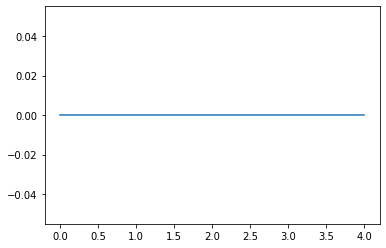

'ecdf = ECDF(toPlot)\nplt.gca().set_aspect(\'equal\', adjustable=\'box\')\nplt.xlabel("p-value")\nplt.xlim(0, 1)\nplt.ylim(0, 1)\nplt.ylabel("fraction of data")\nplt.savefig(\'C:/Users/Admin/Desktop/UFMultimodalBinomial.png\')\nplt.show()'

In [4]:
#np.savetxt('C:/Users/Admin/Desktop/UFIndependenceBinomialNull.csv', power, delimiter=',')
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
#np.savetxt('C:/Users/Admin/Desktop/UFIndependenceBinomialNull2.csv',
               #power, delimiter=',')
toPlot = np.genfromtxt('C:/Users/Admin/Desktop/UFIndependenceBinomialNull2.csv', delimiter=',')
plt.plot(toPlot)
plt.show()
"""ecdf = ECDF(toPlot)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("p-value")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel("fraction of data")
plt.savefig('C:/Users/Admin/Desktop/UFMultimodalBinomial.png')
plt.show()"""